In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install gymnasium
!pip install pygame

In [2]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379371 sha256=a393820cec2d77961c81f9b31dfb44afc7a989e9da5fc9b0a078d6202879f920
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [3]:
import gymnasium as gym

gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

In [23]:
import torch.nn as nn
import torch.optim as optim
import torch

class GaussianActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(64, 64)):
        super().__init__()
        # shared layers
        self.share = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )

        # actor layers. actor_mean estimates the mean of the Gaussian distribution, and actor_log_std estimates the log_std
        self.actor_mean = nn.Linear(hidden_dims[1], output_dim)

        # log_std is safe from having negative values, therefore more stable than estimating std. Since action is bounded from -1 to 1, initialize it as e^-2
        self.actor_log_std = nn.Parameter(torch.ones(output_dim) * -2)

        # critic layer estimates value function
        self.critic = nn.Linear(hidden_dims[1], 1)

    def forward(self, x):
        x = self.share(x)

        # actor's mean layer estimates mean.
        mean = self.actor_mean(x)

        # actor's log_std layer estimates log_std. Then, convert it to std
        log_std = self.actor_log_std
        std = torch.exp(log_std)

        # critic layer estimates value
        value = self.critic(x)

        return mean, std, value


In [58]:
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import LambdaLR


class A2CAgent:
    def __init__(self, env_id, num_episodes=1000, max_steps=500, gamma=0.99, lr=1e-3, num_steps = 5, num_envs = 8, vectorization_mode = "sync"):
        # using vectorized environments to boost training
        # sync is more stable, async is faster
        self.env = gym.make_vec(env_id, num_envs = num_envs, vectorization_mode=vectorization_mode)
        self.num_envs = num_envs
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.gamma = gamma
        self.lr = lr
        self.num_steps = num_steps
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # DEBUG NOTE must use single_action_space, not action_space since action_space.shape has dimension (num_env, num_actions)
        # self.policy_net = GaussianActorCritic(self.env.single_observation_space.shape[0], self.env.action_space.shape[0]).to(self.device)
        self.policy_net = GaussianActorCritic(self.env.single_observation_space.shape[0], self.env.single_action_space.shape[0]).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.global_step = 0  # count optimizer steps

        def linear_decay(step):
            frac = 1.0 - min(step / (self.num_episodes), 1.0)
            return frac

        self.scheduler = LambdaLR(self.optimizer, lr_lambda=linear_decay)
        self.loss = nn.MSELoss()

    # choosing action from policy's probability distribution
    def choose_action(self, state):
        mean, std, _ = self.policy_net(state)
        action_dist = torch.distributions.Normal(mean, std)
        action = action_dist.sample()

        # bipedal walker's action space is bounded to [-1, 1]. Apply tanh function to keep the action in range
        action = torch.tanh(action)
        return action

    # computing the gamma decaying rewards in Monte carlo
    def compute_return(self, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return torch.stack(returns)

    # computing the n step rewards
    def compute_n_step_returns(self, rewards, next_value):

        # Bootstraps the future reward using value estimate
        R = next_value
        returns = []
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return torch.stack(returns)


    # mostly equal to A2C_cartpole
    def train(self):
        episode_rewards = []
        episode_steps = []
        step_sum = 0
        random_seed = 1
        torch.manual_seed(random_seed)

        for episode in tqdm(range(self.num_episodes)):
            state, _ = self.env.reset()
            initial_state = state
            done = np.zeros(self.num_envs, dtype=bool)
            episode_reward = np.zeros(self.num_envs)
            values, rewards, log_probs = [], [], []
            done_mask = np.zeros(self.num_envs, dtype=bool)
            done_steps = np.zeros(self.num_envs)
            steps = 0

            while not np.all(done_mask) and steps < self.max_steps:
                steps += 1
                state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)

                # differs from A2C_cartpole when sampling action
                mean, std, value = self.policy_net(state_tensor)
                action_dist = torch.distributions.Normal(mean, std)
                action = action_dist.sample()

                # not exactly the log probability, but log(probability density) since it is a continuous space
                # sum it in the dimension of num_actions (multiplying probability)
                log_prob = action_dist.log_prob(action).sum(dim=-1)

                # need to move the tensor to the cpu to convert it to numpy
                next_state, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())
                done = np.logical_or(terminated, truncated)
                done_steps = np.where(np.logical_and(done, ~done_mask), steps, done_steps)
                done_mask = np.logical_or(done_mask, done)
                reward = np.where(done_mask, 0.0, reward)

                # saves the values, rewards, log_probs which are used to calculate the n_step returns, actor loss, and critic loss
                values.append(value.squeeze())
                rewards.append(torch.tensor(reward, dtype=torch.float32).to(self.device))
                log_probs.append(log_prob)

                episode_reward += reward
                state = next_state

                # every n steps, calculate losses, update the actor & critic, then refresh the saved lists
                # if (steps % self.num_steps == 0) or np.any(done):
                if np.any(done):
                    with torch.no_grad():
                        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device)
                        _, _, next_value = self.policy_net(next_state_tensor)
                        done_tensor = torch.tensor(done, dtype=torch.float32).to(self.device)
                        next_value = next_value.squeeze() * (1 - done_tensor)

                    # returns = self.compute_n_step_returns(rewards, next_value)  # shape: (n_steps, num_envs)
                    returns = self.compute_return(rewards)
                    returns = returns.transpose(0, 1)  # shape: (num_envs, n_steps)
                    values = torch.stack(values).transpose(0, 1)  # shape: (num_envs, n_steps)
                    log_probs = torch.stack(log_probs).transpose(0, 1)  # shape: (num_envs, n_steps)
                    advantages = returns - values
                    # matching the dimensions fo log_probs

                    # print(steps, "values", values.shape, "returns", returns.shape, "log probs", log_probs.shape)

                    # calculate actor_loss by multiplying log probabilities to advantages. This will decrease the action probability of negative advantages, and vice-versa
                    actor_loss = - (log_probs * advantages.detach()).mean()

                    # updates the critic to find better estimate of values that matches the n-step reward
                    critic_loss = self.loss(returns, values)

                    # print(steps, "\nLOSS", actor_loss, critic_loss, "R/V", returns, values)

                    loss = actor_loss + 0.4 * critic_loss
                    self.optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=0.5)
                    self.optimizer.step()
                    self.scheduler.step()
                    self.global_step += 1

                    # found exploding gradients which are often (~40%) larger than 10, and sometimes(~10%) larger than 100
                    # if episode % 10 == 0:
                    #     total_norm = 0.0
                    #     for p in self.policy_net.parameters():
                    #         if p.grad is not None:
                    #             param_norm = p.grad.data.norm(2)
                    #             total_norm += param_norm.item() ** 2

                    #     total_norm = total_norm ** 0.5
                    #     print(f"Total gradient norm: {total_norm:.6f}")



                    values = []
                    rewards = []
                    log_probs = []

            episode_rewards.append(episode_reward)
            episode_steps.append(steps)

            if episode % 10 == 0:
               print('Episode {}\tlengths: {}\treward: {}]\tfull length: {}'.format(episode, done_steps, episode_reward, steps))
            #    mean, std, value = self.policy_net(torch.tensor(initial_state, dtype=torch.float32).to(self.device))
            #    print('initial dist: {} {}'.format(mean, std))

            episode_rewards.append(episode_reward)
            episode_steps.append(steps)

        self.env.close()
        return np.array(episode_rewards)


In [60]:
import gymnasium as gym

env_id = 'LunarLanderContinuous-v3'
gamma = 0.99
num_episodes = 500
max_steps = 500
num_steps = 8
num_envs = 4
lr = 1e-4

a2c_model =  A2CAgent(env_id, num_episodes=num_episodes, num_envs=num_envs, max_steps=max_steps, lr=lr, num_steps = num_steps)

rewards = a2c_model.train()

  0%|          | 1/500 [00:00<04:42,  1.76it/s]

Episode 0	lengths: [116. 115.  76. 132.]	reward: [ 61.91539951 -25.63076158  13.96758944  33.86987287]]	full length: 132


  2%|▏         | 11/500 [00:03<02:37,  3.11it/s]

Episode 10	lengths: [151.  85.  92.  88.]	reward: [ -86.87423612 -109.80215293  -45.28348767 -215.96646525]]	full length: 151


  4%|▍         | 21/500 [00:07<03:00,  2.65it/s]

Episode 20	lengths: [138.  96. 136. 113.]	reward: [ -55.17467451  -60.78502685   -3.01915082 -171.8531476 ]]	full length: 138


  6%|▌         | 31/500 [00:10<02:37,  2.98it/s]

Episode 30	lengths: [147. 106. 165. 109.]	reward: [  20.48490107 -178.7011114   -29.17050297  -43.03049952]]	full length: 165


  8%|▊         | 41/500 [00:13<02:21,  3.23it/s]

Episode 40	lengths: [101. 143.  96.  91.]	reward: [-114.87410805   -7.72869187 -185.67003047  117.28802426]]	full length: 143


 10%|█         | 51/500 [00:17<02:59,  2.50it/s]

Episode 50	lengths: [101. 100. 124.  87.]	reward: [-140.47469294  -34.45134213 -189.99236898   71.07503769]]	full length: 124


 12%|█▏        | 61/500 [00:20<02:14,  3.26it/s]

Episode 60	lengths: [129.  72. 120. 121.]	reward: [  27.20245783  -32.96407702 -192.95611725 -200.47861508]]	full length: 129


 14%|█▍        | 71/500 [00:24<02:18,  3.09it/s]

Episode 70	lengths: [118. 107. 149.  95.]	reward: [  23.62571456   16.30684758 -211.19358924 -202.15905537]]	full length: 149


 16%|█▌        | 81/500 [00:27<02:14,  3.12it/s]

Episode 80	lengths: [104. 110.  69. 117.]	reward: [  21.5467274  -151.71790407  -45.34727817  -72.04246962]]	full length: 117


 18%|█▊        | 91/500 [00:31<02:40,  2.56it/s]

Episode 90	lengths: [ 90. 164. 159.  84.]	reward: [-190.29131271 -110.46881559  -15.34931941   19.71648659]]	full length: 164


 20%|██        | 101/500 [00:34<01:55,  3.44it/s]

Episode 100	lengths: [107.  96.  82.  78.]	reward: [-226.14815366  -12.06285957   28.58940944   33.39293807]]	full length: 107


 22%|██▏       | 111/500 [00:37<02:10,  2.99it/s]

Episode 110	lengths: [114. 108.  78. 128.]	reward: [ -40.54287115 -251.46114391    3.0339493   -26.95934549]]	full length: 128


 24%|██▍       | 121/500 [00:41<02:18,  2.74it/s]

Episode 120	lengths: [ 87.  79.  80. 105.]	reward: [-71.58017619  35.05564481 -94.00411909  37.84672444]]	full length: 105


 26%|██▌       | 131/500 [00:44<01:57,  3.15it/s]

Episode 130	lengths: [ 63. 103. 100. 135.]	reward: [  32.16972586 -212.12507292   19.26642912 -167.63619879]]	full length: 135


 28%|██▊       | 141/500 [00:48<02:03,  2.90it/s]

Episode 140	lengths: [ 81.  96.  97. 164.]	reward: [  54.07713462  -56.67571579 -174.75196024  -81.36381697]]	full length: 164


 30%|███       | 151/500 [00:51<02:07,  2.75it/s]

Episode 150	lengths: [ 90. 130. 147. 188.]	reward: [-163.86978553   45.8716239    31.03246011  -57.9906571 ]]	full length: 188


 32%|███▏      | 161/500 [00:56<03:41,  1.53it/s]

Episode 160	lengths: [ 75.  76.   0. 128.]	reward: [  -8.93565204 -102.63669287   96.57302317 -221.70515777]]	full length: 500


 34%|███▍      | 171/500 [00:59<01:52,  2.93it/s]

Episode 170	lengths: [172. 112. 105. 108.]	reward: [-136.91540704   10.60469257 -191.83740132   22.02873576]]	full length: 172


 36%|███▌      | 181/500 [01:02<01:38,  3.23it/s]

Episode 180	lengths: [103.  85.  94. 100.]	reward: [  47.61151646   43.73301089 -124.24292652 -206.52571642]]	full length: 103


 38%|███▊      | 191/500 [01:06<01:52,  2.74it/s]

Episode 190	lengths: [ 89.  93. 111.  94.]	reward: [-249.50207309 -171.59795842 -103.15750233 -188.70397411]]	full length: 111


 40%|████      | 201/500 [01:09<01:36,  3.10it/s]

Episode 200	lengths: [147.  97. 167.  80.]	reward: [-118.96817863 -141.87025847   -4.16002481   21.61099009]]	full length: 167


 42%|████▏     | 211/500 [01:12<01:23,  3.48it/s]

Episode 210	lengths: [ 95. 102. 110. 104.]	reward: [-176.61371542 -131.95570272  -96.57253616 -152.04257332]]	full length: 110


 44%|████▍     | 221/500 [01:15<01:29,  3.13it/s]

Episode 220	lengths: [81. 95. 65. 85.]	reward: [-4.12488503  1.4727436  64.71205835 27.04212284]]	full length: 95


 46%|████▌     | 231/500 [01:19<01:43,  2.61it/s]

Episode 230	lengths: [154. 114.  80.  68.]	reward: [   7.66887777 -191.62941273    5.72989919  -22.9267737 ]]	full length: 154


 48%|████▊     | 241/500 [01:22<01:17,  3.33it/s]

Episode 240	lengths: [109.  85.  93.  65.]	reward: [  15.3728457     5.65243315 -157.31151706   60.83559721]]	full length: 109


 50%|█████     | 251/500 [01:25<01:23,  2.98it/s]

Episode 250	lengths: [145.  89.  84. 103.]	reward: [ -18.91509694 -167.76975072 -167.93865657  -32.95425479]]	full length: 145


 52%|█████▏    | 261/500 [01:29<01:40,  2.39it/s]

Episode 260	lengths: [145.  93.  71.  87.]	reward: [-161.17369334 -199.73804618   75.45600553    4.86473883]]	full length: 145


 54%|█████▍    | 271/500 [01:33<01:23,  2.74it/s]

Episode 270	lengths: [ 94. 140.  66.  71.]	reward: [  17.28144456 -239.7707828   -47.47162765   31.64958815]]	full length: 140


 56%|█████▌    | 281/500 [01:36<01:06,  3.28it/s]

Episode 280	lengths: [101. 141. 134. 125.]	reward: [-117.75853097 -194.28979727 -206.22669597    4.14725709]]	full length: 141


 58%|█████▊    | 291/500 [01:39<01:11,  2.91it/s]

Episode 290	lengths: [76. 92. 76. 78.]	reward: [  39.73455453 -276.08370154  -38.78394949   -3.09399004]]	full length: 92


 60%|██████    | 301/500 [01:43<01:16,  2.60it/s]

Episode 300	lengths: [122.  99.  74. 134.]	reward: [  -1.36560441 -181.85652211   90.76470391  -67.32093197]]	full length: 134


 62%|██████▏   | 311/500 [01:46<00:55,  3.38it/s]

Episode 310	lengths: [ 93.  94. 109. 108.]	reward: [-152.84894799   22.6729832    35.1319097  -209.94540475]]	full length: 109


 64%|██████▍   | 321/500 [01:49<01:01,  2.93it/s]

Episode 320	lengths: [109.  91.  89.  89.]	reward: [-185.45711648   49.50042085  -35.94867216   -7.19605435]]	full length: 109


 66%|██████▌   | 331/500 [01:53<01:06,  2.56it/s]

Episode 330	lengths: [ 92. 130.  69. 162.]	reward: [  -2.79236857 -120.12333983   56.43920577 -162.92194034]]	full length: 162


 68%|██████▊   | 341/500 [01:57<00:50,  3.16it/s]

Episode 340	lengths: [102.  71.  99.  83.]	reward: [  -3.67609441  -40.9798059  -222.44794985   19.41781969]]	full length: 102


 70%|███████   | 351/500 [02:00<00:51,  2.90it/s]

Episode 350	lengths: [132.  77.  68.  90.]	reward: [-136.87280015   66.03996425   58.57238495 -210.17850611]]	full length: 132


 72%|███████▏  | 361/500 [02:03<00:44,  3.10it/s]

Episode 360	lengths: [100. 119.  92. 118.]	reward: [ -10.13928548  -52.38771247   -1.98614472 -242.35444751]]	full length: 119


 74%|███████▍  | 371/500 [02:07<00:52,  2.44it/s]

Episode 370	lengths: [ 68. 118. 137. 179.]	reward: [  32.17927553 -220.90165487  -56.76574089  -89.47795366]]	full length: 179


 76%|███████▌  | 381/500 [02:12<01:02,  1.89it/s]

Episode 380	lengths: [125.  99.  87.  72.]	reward: [  26.23173512 -174.84745198   45.40017595   47.60981376]]	full length: 125


 78%|███████▊  | 391/500 [02:15<00:36,  2.98it/s]

Episode 390	lengths: [139. 101. 146. 107.]	reward: [ -18.6570094  -125.02285903  -65.95733317 -231.10894219]]	full length: 146


 80%|████████  | 401/500 [02:21<01:00,  1.64it/s]

Episode 400	lengths: [72.  0. 85. 77.]	reward: [ 28.80532299 130.07540509  -3.65289014 -44.58142318]]	full length: 500


 82%|████████▏ | 411/500 [02:24<00:28,  3.14it/s]

Episode 410	lengths: [122. 128.  88.  90.]	reward: [-90.36017123  36.41918413  26.45334147 -60.06524781]]	full length: 128


 84%|████████▍ | 421/500 [02:27<00:24,  3.18it/s]

Episode 420	lengths: [118. 105.  77. 104.]	reward: [  15.75954669   45.69112345  -85.60112324 -211.28306156]]	full length: 118


 86%|████████▌ | 431/500 [02:31<00:24,  2.83it/s]

Episode 430	lengths: [98. 79. 80. 83.]	reward: [-162.34444978  -77.37382427    9.38534601   86.48202705]]	full length: 98


 88%|████████▊ | 441/500 [02:34<00:16,  3.51it/s]

Episode 440	lengths: [99. 81. 96. 92.]	reward: [-148.32634392   64.81063379 -218.1765968  -148.54577373]]	full length: 99


 90%|█████████ | 451/500 [02:37<00:14,  3.28it/s]

Episode 450	lengths: [ 80.  75. 106.  89.]	reward: [ -18.32739747   39.31187398 -117.6405076  -163.74347118]]	full length: 106


 92%|█████████▏| 461/500 [02:41<00:12,  3.00it/s]

Episode 460	lengths: [ 73. 165. 136. 100.]	reward: [  15.1868075  -214.50398172 -193.01003718  -30.7112943 ]]	full length: 165


 94%|█████████▍| 471/500 [02:46<00:10,  2.65it/s]

Episode 470	lengths: [119.  73. 111.  85.]	reward: [-245.22891696   31.10354889  -40.71188746 -108.59367543]]	full length: 119


 96%|█████████▌| 481/500 [02:49<00:05,  3.43it/s]

Episode 480	lengths: [104. 100. 103. 125.]	reward: [-212.87044846 -206.96615401 -145.16968455  -97.28598462]]	full length: 125


 98%|█████████▊| 491/500 [02:52<00:02,  3.03it/s]

Episode 490	lengths: [108.  97. 106. 104.]	reward: [  27.48877095   42.72716848  -31.12433913 -194.65016576]]	full length: 108


100%|██████████| 500/500 [02:56<00:00,  2.84it/s]


In [61]:
import numpy as np
import torch

env = gym.make('LunarLanderContinuous-v3', render_mode='rgb_array')

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

frames = []
episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            mean, std, _ = a2c_model.policy_net(state)
            action = mean.cpu().numpy().squeeze()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        if i == 0:
            frame = env.render()
            frames.append(frame)

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


Episode 1 Reward: -299.6925579407408
Episode 2 Reward: -437.8350417241302
Episode 3 Reward: -365.15915703238403
Episode 4 Reward: -41.480207231990946
Episode 5 Reward: -67.86160016317797
Episode 6 Reward: -236.1140008755655
Episode 7 Reward: -17.73000548066765
Episode 8 Reward: -287.5551156947084
Episode 9 Reward: -82.14923817312703
Episode 10 Reward: -362.0109605614747
Average Reward over 10 episodes: -219.75878848779672


In [65]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make('LunarLanderContinuous-v3', render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            mean, std, _ = a2c_model.policy_net(state)
            action = mean.cpu().numpy().squeeze()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1 Reward: -438.44997844223667
Episode 2 Reward: -360.34712015380285
Episode 3 Reward: -390.9824498787228
Episode 4 Reward: -94.64395685930262
Episode 5 Reward: -324.25729629706086
Episode 6 Reward: -143.24198070473562
Episode 7 Reward: -440.270445675723
Episode 8 Reward: -331.73763154806136
Episode 9 Reward: -14.819166016082875
Episode 10 Reward: -245.76707294152493
Average Reward over 10 episodes: -278.45170985172535


Average reward over 10 test episodes: -169.90


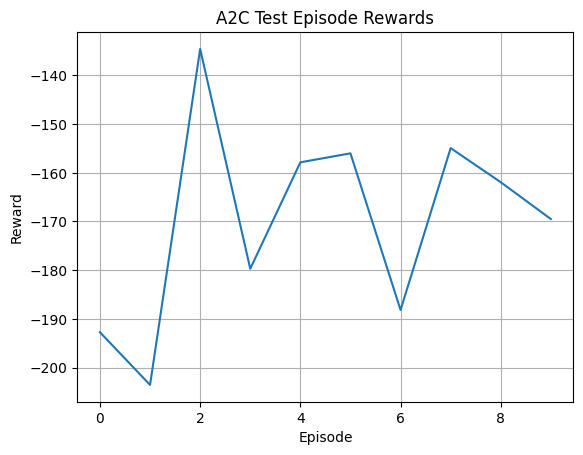

In [16]:
import matplotlib.pyplot as plt

env = gym.make('LunarLanderContinuous-v3')
test_episodes = 10
test_rewards = []

for _ in range(test_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(a2c_model.device)
            mean, std, _ = a2c_model.policy_net(state_tensor)
            action = mean

        next_state, reward, terminated, truncated, _ = env.step(action.cpu().numpy().squeeze(0))
        done = terminated or truncated
        ep_reward += reward
        state = next_state

    test_rewards.append(ep_reward)


print(f"Average reward over {test_episodes} test episodes: {np.mean(test_rewards):.2f}")

plt.plot(test_rewards)
plt.title("A2C Test Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


In [ ]:
import gymnasium as gym
import numpy as np


env = gym.make('LunarLanderContinuous-v3')
test_episodes = 10
random_rewards = []

for ep in range(test_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action = env.action_space.sample()  # random continuous action
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ep_reward += reward

    random_rewards.append(ep_reward)
    print(f"Episode {ep+1} reward: {ep_reward:.2f}")

env.close()

avg_reward = np.mean(random_rewards)
print(f"\n✅ Average reward over {test_episodes} random episodes: {avg_reward:.2f}")


In [ ]:
# from tqdm import tqdm
# import torch.profiler

# n_envs = 1
# envs = [gym.make('LunarLanderContinuous-v3') for _ in range(n_envs)]

# n_states = envs[0].observation_space.shape[0]
# n_actions = envs[0].action_space.shape[0]

# actor_network = GaussianActor(n_states, n_actions)
# critic_network = Critic(n_states)

# state_normalizer = Normalizer(shape=(envs[0].observation_space.shape[0],))
# optimizer = optim.Adam(list(actor_network.parameters()) + list(critic_network.parameters()), lr=initial_lr)
# mse_loss = nn.MSELoss()

# max_step = 1600
# states, actions, log_probs, rewards, values, dones, entropies = [], [], [], [], [], [], []


# for ep in tqdm(range(episodes)):
#     states, rewards, dones, values, actions = [], [], [], [], []
#     ep_reward = 0
#     latest_debug_info = {}

#     for env in envs:
#         state, _ = env.reset()
#         done = False
#         steps = 0

#         while not done:
#             state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
#             mean, std = actor_network(state_tensor)
#             dist = torch.distributions.Normal(mean, std)
#             action = dist.sample()
#             log_prob = dist.log_prob(action).sum(dim=-1)
#             entropy = dist.entropy().sum(dim=-1)
#             value = critic_network(state_tensor)
#             steps += 1

#             next_state, reward, terminated, truncated, _ = env.step(action.detach().numpy().squeeze(0))
#             done = terminated or truncated or steps > max_step

#             states.append(state_tensor)
#             actions.append(action)
#             log_probs.append(log_prob)
#             values.append(value)
#             rewards.append(reward)
#             dones.append(done)
#             entropies.append(entropy)
#             ep_reward += reward

#             if len(rewards) >= num_steps or done:

#                 next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
#                 if dones[-1]:
#                     bootstrap_value = 0
#                 else:
#                     bootstrap_value = critic_network(next_state_tensor).item()

#                 returns = []
#                 R = bootstrap_value
#                 for i in reversed(range(len(rewards))):
#                     R = rewards[-1 - i] + gamma * R
#                     returns.insert(0, R)
#                 returns = torch.tensor(returns, dtype=torch.float32)

#                 values_tensor = torch.stack(values[-num_steps:]).squeeze(-1)
#                 log_probs_tensor = torch.stack(log_probs[-num_steps:]).squeeze(-1)
#                 entropies_tensor = torch.stack(entropies[-num_steps:]).squeeze(-1)
#                 returns_tensor = returns.clone().detach()
#                 advantages = returns - values_tensor
#                 clipped_advantages = torch.clamp(advantages, min=-10.0, max=10.0)

#                 policy_loss = -(log_probs_tensor * clipped_advantages.detach()).mean()
#                 value_loss = mse_loss(values_tensor, returns_tensor)
#                 entropy_loss = -entropies_tensor.mean()

#                 # total_loss = policy_loss + 0.5 * value_loss + 0.001 * entropy_loss
#                 total_loss = policy_loss + 0.4 * value_loss    #following rl-baselines3-zoo

#                 optimizer.zero_grad()
#                 total_loss.backward()
#                 grad_norm = torch.nn.utils.clip_grad_norm_(
#                     list(actor_network.parameters()) + list(critic_network.parameters()),
#                     max_norm=0.5
#                 )
#                 optimizer.step()


#                 latest_debug_info = {
#                     "values": values_tensor,
#                     "returns": returns,
#                     "log_probs": log_probs_tensor,
#                     "entropies": entropies_tensor,
#                     "policy_loss": policy_loss,
#                     "value_loss": value_loss,
#                     "grad_norm": grad_norm
#                 }


#                 states, actions, log_probs, rewards, values, dones, entropies = [], [], [], [], [], [], []

#             state = next_state


#     if ep % 10 == 0 and latest_debug_info:
#         a2c_debug_log(ep, steps, ep_reward, **latest_debug_info)

In [ ]:
def a2c_debug_log(ep, steps, ep_reward, values, returns, log_probs, entropies, policy_loss, value_loss, grad_norm):
    advantages = returns - values

    print(f"\n[Episode {ep}] Debug Summary")
    print(f"# of Steps:         {steps:.2f}")
    print(f"Total Reward:       {ep_reward:.2f}")
    print(f"Mean V(s):          {values.mean().item():.4f}")
    print(f"Advantage Mean:     {advantages.mean().item():.4f}")
    print(f"Advantage Std:      {advantages.std().item():.4f}")
    print(f"Entropy (avg):      {entropies.mean().item():.4f}")
    print(f"Policy Loss:        {policy_loss.item():.4f}")
    print(f"Value Loss:         {value_loss.item():.4f}")
    print(f"Gradient Norm:      {grad_norm:.4f}")
    print(f"Log Prob Mean:      {log_probs.mean().item():.4f}")
    print("-" * 50)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# class Normalizer:
#     def __init__(self, shape, epsilon=1e-8):
#         self.shape = shape
#         self.mean = np.zeros(shape)
#         self.var = np.ones(shape)
#         self.count = epsilon

#     def update(self, x):
#         batch_mean = np.mean(x, axis=0)
#         batch_var = np.var(x, axis=0)

#         batch_size = x.shape[0]
#         self.count += batch_size
#         self.mean += (batch_mean - self.mean) * batch_size / self.count
#         self.var += (batch_var - self.var) * batch_size / self.count

#     def normalize(self, x):
#         return (x - self.mean) / np.sqrt(self.var + 1e-8)


def compute_gae(rewards, values, next_values, dones, gamma, gae_lambda):
    advantages = []
    advantage = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * next_values[i] * dones[i] - values[i]
        advantage = delta + gamma * gae_lambda * dones[i] * advantage
        advantages.insert(0, advantage)
    return advantages

